Combined shape: (2475912, 15)

Using columns: ['source_file', 'Timestamp', 'RPM', 'Speed_kmh', 'MAF_gps']

Preview after cleaning:


,source_file,Timestamp,RPM,Speed_kmh,MAF_gps
2,2017-07-10_Seat_Leon_KA_KA_Stau.csv,08:57:05.703,768.0,NaN,NaN
3,2017-07-10_Seat_Leon_KA_KA_Stau.csv,08:57:05.793,768.0,0.0,NaN
4,2017-07-10_Seat_Leon_KA_KA_Stau.csv,08:57:05.883,768.0,0.0,NaN
5,2017-07-10_Seat_Leon_KA_KA_Stau.csv,08:57:05.971,768.0,0.0,7.22
6,2017-07-10_Seat_Leon_KA_KA_Stau.csv,08:57:06.062,768.0,0.0,7.22


🕐 Using time column: Timestamp

Fuel efficiency summary (L/100km):


count    2.155449e+06
mean     2.757452e-01
std      3.523303e-01
min      0.000000e+00
25%      1.212651e-01
50%      1.714737e-01
75%      2.833898e-01
max      6.027500e+00
Name: L_per_100km, dtype: float64

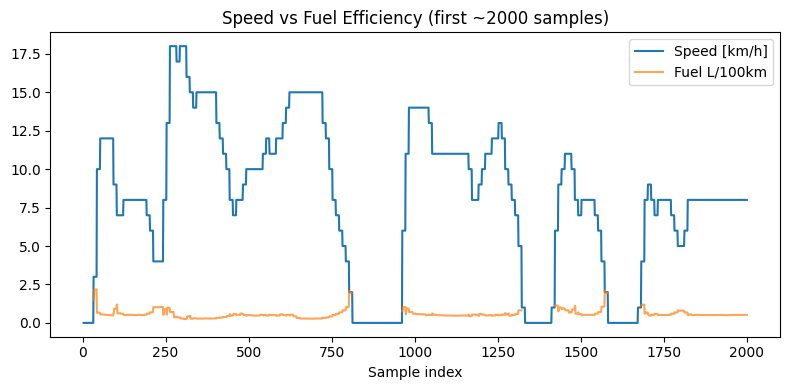


✅ Saved combined dataset to ../data/cleaned_kit_obd_combined.csv


In [7]:
# 03_data_processing.ipynb — KIT OBD-II
# Objective: Combine all trips, compute sampling interval, and estimate fuel usage

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- 1. Load and combine all CSV files ---
data_dir = Path("../data/ODB-II-Dataset")
all_files = sorted(data_dir.glob("*.csv"))

dfs = []
for f in all_files:
    try:
        df_temp = pd.read_csv(f)
        df_temp["source_file"] = f.name  # keep track of trip
        dfs.append(df_temp)
    except Exception as e:
        print(f"⚠️ Skipped {f.name}: {e}")

if not dfs:
    raise RuntimeError("No valid CSVs found in dataset folder.")

df = pd.concat(dfs, ignore_index=True)
print(f"Combined shape: {df.shape}")

# Normalize column names: strip spaces and unify case
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()


# --- 2. Select and rename useful columns ---
rename_map = {
    "engine_rpm_[rpm]": "RPM",
    "vehicle_speed_sensor_[km/h]": "Speed_kmh",
    "air_flow_rate_from_mass_flow_sensor_[g/s]": "MAF_gps",
    "time": "Timestamp",  # covers "Time", "Time ", etc.
    "gps_time": "Timestamp"
}


# Rename known columns (only if present)
df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

# Dynamically select columns that exist
cols_to_keep = ["source_file", "Timestamp", "Time_s", "RPM", "Speed_kmh", "MAF_gps"]
existing_cols = [c for c in cols_to_keep if c in df.columns]

df = df[existing_cols].copy()
print(f"\nUsing columns: {existing_cols}")

# Drop rows with all NaNs in key signals
df = df.dropna(subset=["RPM", "Speed_kmh", "MAF_gps"], how="all")

print("\nPreview after cleaning:")
display(df.head())

# --- 3. Parse timestamps and compute sampling interval ---
time_col = None
for candidate in ["Timestamp", "Time", "time", "Time_", "time_"]:
    if candidate in df.columns:
        time_col = candidate
        break

if time_col:
    print(f"🕐 Using time column: {time_col}")
    # Parse time (no date part, so just use a dummy date)
    df["Timestamp"] = pd.to_datetime(
        "2025-01-01 " + df[time_col].astype(str), errors="coerce", format="%Y-%m-%d %H:%M:%S.%f"
    )

    # Compute sampling interval per file
    df = df.sort_values(["source_file", "Timestamp"])
    df["dt_s"] = df.groupby("source_file")["Timestamp"].diff().dt.total_seconds()

    # If intervals missing, fill with median per trip
    df["dt_s"] = df.groupby("source_file")["dt_s"].transform(lambda x: x.fillna(x.median()))
else:
    print("⚠️ No time column found — generating synthetic timestamps assuming 10 Hz sampling rate.")
    df["Time_s"] = df.groupby("source_file").cumcount() / 10.0
    df["dt_s"] = 0.1




# --- 4. Estimate fuel usage ---
# Fuel rate (g/s) = MAF (g/s)
# Convert to L/s assuming gasoline density ~ 720 g/L
df["fuel_L_s"] = df["MAF_gps"] / 720.0

# Instantaneous fuel consumption (L/100km)
# fuel (L/s) / speed (km/h) * 3600 * 100
df["L_per_100km"] = np.where(
    df["Speed_kmh"] > 1,
    (df["fuel_L_s"] / (df["Speed_kmh"] / 3.6)) * 100,
    np.nan
)

print("\nFuel efficiency summary (L/100km):")
display(df["L_per_100km"].describe())

# --- 5. Simple visual check ---
plt.figure(figsize=(8, 4))
plt.plot(df["Speed_kmh"].iloc[:2000], label="Speed [km/h]")
plt.plot(df["L_per_100km"].iloc[:2000], label="Fuel L/100km", alpha=0.7)
plt.title("Speed vs Fuel Efficiency (first ~2000 samples)")
plt.xlabel("Sample index")
plt.legend()
plt.tight_layout()
plt.show()

# --- Save cleaned dataset ---
output_file = "../data/cleaned_kit_obd_combined.csv"
df.to_csv(output_file, index=False)
print(f"\n✅ Saved combined dataset to {output_file}")
